![alt text](download.png)

## This final project focuses on leveraging the techniques and concepts you've learned throughout this course. 
- You will apply image processing, feature extraction, and pattern recognition methods to solve real-world challenges. Specifically, you will implement and fine-tune state-of-the-art algorithms like Convolutional Neural Networks (CNNs), object detection, image segmentation, or even feature matching.

we'll build a CNN using Keras to use it classifying thousands of pictures in six different categories

Data link : https://www.kaggle.com/puneet6060/intel-image-classification

# Import Libraries

In [1]:
!pip install pandas

You should consider upgrading via the 'G:\data science certificates\GUI project\myenv310\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install numpy seaborn matplotlib opencv-python tqdm scikit-learn tensorflow==2.8.0


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'g:\data science certificates\GUI project\myenv310\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tensorflow as tf

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input, Flatten, Dropout, Dense
from tensorflow.keras.regularizers import l1_l2,l1, l2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2, InceptionV3, VGG16, VGG19, DenseNet201

import random
random.seed(42)

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
os.getcwd()
train_path='G:/data science certificates/cnn/seg_train/seg_train'
test_path='G:/data science certificates/cnn/seg_test/seg_test'
pred_path='G:/data science certificates/cnn/seg_pred/seg_pred'

In [5]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_code(n):
    for x,y in code.items():
        if n==y:
            return x
get_code(3)

'mountain'

In [6]:

def get_image_sizes(image_path, is_subfolder=False):
    """
    This function calculates the sizes of images in the given path.

    Parameters:
    - image_path: Path where images are stored.
    - is_subfolder: Set to True if the images are in subfolders (like train/test sets).

    Returns:
    - A pandas Series with the count of each image size.
    """
    sizes = []

    if is_subfolder:
        for folder in os.listdir(image_path):
            images = gb.glob(pathname=str(image_path + '/' + folder + '/*.jpg'))
            for img in images:
                image = plt.imread(img)
                sizes.append(image.shape)
    else:
        files = gb.glob(pathname=str(image_path + '/*.jpg'))
        for file in files:
            image = plt.imread(file)
            sizes.append(image.shape)

    return pd.Series(sizes).value_counts()

# Usage examples
train_sizes = get_image_sizes(train_path, is_subfolder=True)
test_sizes = get_image_sizes(test_path, is_subfolder=True)
pred_sizes = get_image_sizes(pred_path, is_subfolder=False)

print("Train Image Sizes\n", train_sizes)
print("Test Image Sizes:\n", test_sizes)
print("Prediction Image Sizes:\n", pred_sizes)

Train Image Sizes
 (150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(144, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(105, 150, 3)        1
(97, 150, 3)         1
(131, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(141, 150, 3)        1
(100, 150, 3)        1
(103, 150, 3)        1
(76, 150, 3)         1
(120, 150, 3)        1
(102, 150, 3)        1
(119, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(110, 150, 3)        1
(149, 150, 3)        1
(140, 150, 3)        1
Name: count, dtype: int64
Test Image Sizes:
 (150, 150, 3)    2993
(141, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(149, 150, 3)       1
(72, 150, 3)        1
(131, 150, 3)       1
(81, 150, 3)        1
Name: count, dtype: int64
Prediction Image Size

In [7]:
def load_images(image_path, code, resize_shape=(100, 100), is_subfolder=True):
    """
    Loads and resizes images from the specified path.

    Parameters:
    - image_path: Path where images are stored.
    - code: A dictionary mapping folder names to labels.
    - resize_shape: Tuple specifying the new size for resizing images (default is (100, 100)).
    - is_subfolder: Boolean indicating if images are in subfolders (T|rue for train/test, False for prediction).

    Returns:
    - x_data: A NumPy array of resized images.
    - y_data: Corresponding labels (if applicable, else returns None for prediction data).
    """
    x_data = []
    y_data = []

    if is_subfolder:
        for folder in os.listdir(image_path):
            folder_path = os.path.join(image_path, folder)
            images = gb.glob(pathname=os.path.join(folder_path, '*.jpg'))
            for img_path in images:
                image = plt.imread(img_path)  # Alternatively, you can use cv2.imread for BGR images
                image_resized = cv2.resize(image, resize_shape)
                # normalized_image = image_resized / 255.0
                x_data.append(image_resized)
                y_data.append(code[folder])  # Append the folder's label
    else:
        images = gb.glob(pathname=os.path.join(image_path, '*.jpg'))
        for img_path in images:
            # image = cv2.imread(img_path)
            image = plt.imread(img_path)
            image_resized = cv2.resize(image, resize_shape)
            # normalized_image = image_resized / 255.0
            x_data.append(image_resized)
        y_data = None  # No labels for prediction data

    return np.array(x_data), np.array(y_data)

In [8]:
# Usage for train data
x_train_1, y_train_1 = load_images(train_path, code, resize_shape=(100, 100), is_subfolder=True)

# Usage for test data
x_test_1, y_test_1 = load_images(test_path, code, resize_shape=(100, 100), is_subfolder=True)

# Usage for prediction data (no labels)
x_pred_1, _ = load_images(pred_path, code=None, resize_shape=(100, 100), is_subfolder=False)

print(f"x_train shape: {x_train_1.shape}, y_train shape: {y_train_1.shape}")
print(f"x_test shape: {x_test_1.shape}, y_test shape: {y_test_1.shape}")
print(f"x_pred shape: {x_pred_1.shape}")

x_train shape: (14034, 100, 100, 3), y_train shape: (14034,)
x_test shape: (3000, 100, 100, 3), y_test shape: (3000,)
x_pred shape: (7300, 100, 100, 3)


In [9]:
x_train=np.array(x_train_1)
x_test=np.array(x_test_1)

y_train = to_categorical(np.array(y_train_1), num_classes=6)
y_test = to_categorical(np.array(y_test_1), num_classes=6)

x_pred=np.array(x_pred_1)

In [10]:
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

print(x_pred.shape)

(14034, 100, 100, 3)
(3000, 100, 100, 3)
(14034, 6)
(3000, 6)
(7300, 100, 100, 3)


In [11]:
def generate_confusion_matrix_and_metrics(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)

    # Check the shape of y_pred and y_test
    print(f"y_pred shape: {y_pred.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Handle binary and multi-class predictions
    if len(y_pred.shape) == 1:  # Binary classification
        y_pred_classes = (y_pred > 0.5).astype(int)
    else:  # Multi-class classification
        y_pred_classes = np.argmax(y_pred, axis=1)

    # Check the shape after prediction conversion
    print(f"y_pred_classes shape: {y_pred_classes.shape}")

    # Check true labels
    if len(y_test.shape) == 1:  # if y_test is one-dimensional
        y_true = y_test.astype(int)  # assuming y_test contains class indices directly
    else:
        y_true = np.argmax(y_test, axis=1)  # True classes in one-hot encoded format

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    labels = list(code.values())
    target_names = list(code.keys())

    report = classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, labels=labels, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')


# Image Augmentation

In [12]:


train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# Create generators
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=64
)

val_generator = val_datagen.flow(
    x_test,
    y_test,
    batch_size=64
)
# Model Creation

# implement a custom Model

In [13]:


KerasModel = tf.keras.models.Sequential([
    Input(shape=(100, 100, 3)),

    Conv2D(64, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(64, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(64, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    Conv2D(128, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(128, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    Conv2D(256, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(256, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(256, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    Conv2D(512, activation='relu', kernel_size=(3,3), padding='same'),
    Conv2D(512, activation='relu', kernel_size=(3,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2),strides=2),

    GlobalAveragePooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(rate=0.8),
    Dense(6, activation='softmax')
])
KerasModel.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       7

In [14]:
KerasModel.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model_save_path = os.path.expanduser("~/Desktop/bestmodel.h5")

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1  # Verbosity mode, 1 = save messages
)

# Reduce Learning rate when loss is not decreasing
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=4,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001)

# Define Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    #start_from_epoch=0
    )

# Train the model with the ModelCheckpoint callback

In [ ]:

history = KerasModel.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),  # Make sure to include validation data
    epochs=10,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint, reduce_lr, early_stop]  # Pass the checkpoint callback here
)


Epoch 1/10
220/220 [==============================] - ETA: 0s - loss: 1.1234 - accuracy: 0.5993
Epoch 1: val_loss improved from inf to 1.49965, saving model to C:\Users\osc/Desktop\bestmodel.h5
220/220 [==============================] - 2136s 10s/step - loss: 1.1234 - accuracy: 0.5993 - val_loss: 1.4997 - val_accuracy: 0.3680 - lr: 1.0000e-04
Epoch 2/10
220/220 [==============================] - ETA: 0s - loss: 0.7080 - accuracy: 0.7485
Epoch 2: val_loss improved from 1.49965 to 0.92984, saving model to C:\Users\osc/Desktop\bestmodel.h5
220/220 [==============================] - 2164s 10s/step - loss: 0.7080 - accuracy: 0.7485 - val_loss: 0.9298 - val_accuracy: 0.6610 - lr: 1.0000e-04
Epoch 3/10
220/220 [==============================] - ETA: 0s - loss: 0.5834 - accuracy: 0.7966
Epoch 3: val_loss did not improve from 0.92984
220/220 [==============================] - 2213s 10s/step - loss: 0.5834 - accuracy: 0.7966 - val_loss: 1.8233 - val_accuracy: 0.4447 - lr: 1.0000e-04
Epoch 4/10
2

In [17]:
loss,accuracy=KerasModel.evaluate(x_test,y_test)

94/94 [==============================] - 127s 1s/step - loss: 0.5512 - accuracy: 0.8193


In [18]:
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')


loss is 0.5512130856513977
accuracy is 0.8193333148956299


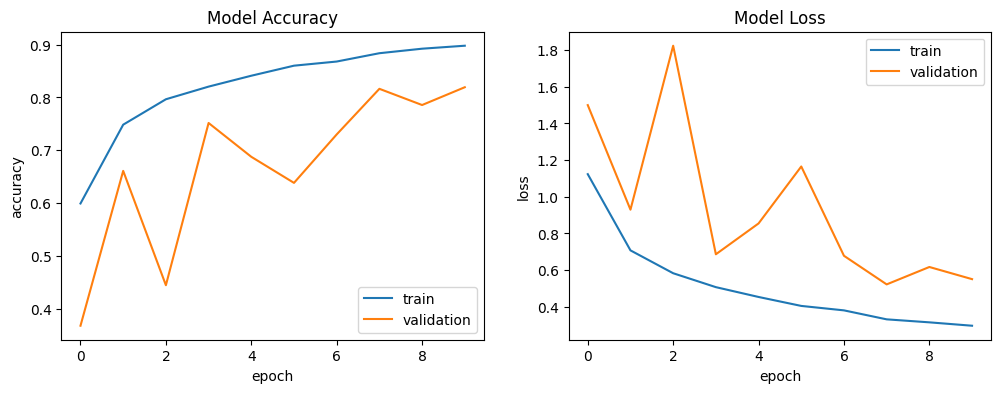

In [19]:
plt.figure(figsize=(12,4))
#  "Accuracy"
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
#  "Loss"
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


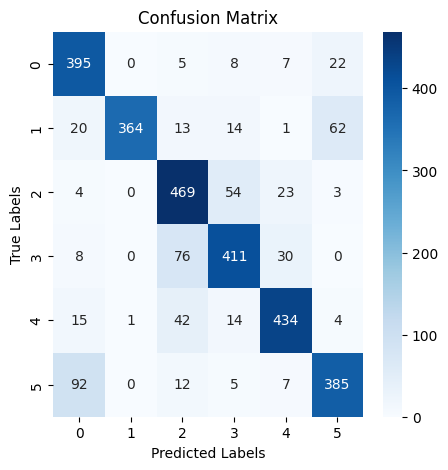

Classification Report:
              precision    recall  f1-score   support

   buildings       0.74      0.90      0.81       437
      forest       1.00      0.77      0.87       474
     glacier       0.76      0.85      0.80       553
    mountain       0.81      0.78      0.80       525
         sea       0.86      0.85      0.86       510
      street       0.81      0.77      0.79       501

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000

Precision: 0.8296
Recall: 0.8193
F1-score: 0.8203


In [20]:
generate_confusion_matrix_and_metrics(KerasModel, x_test, y_test)

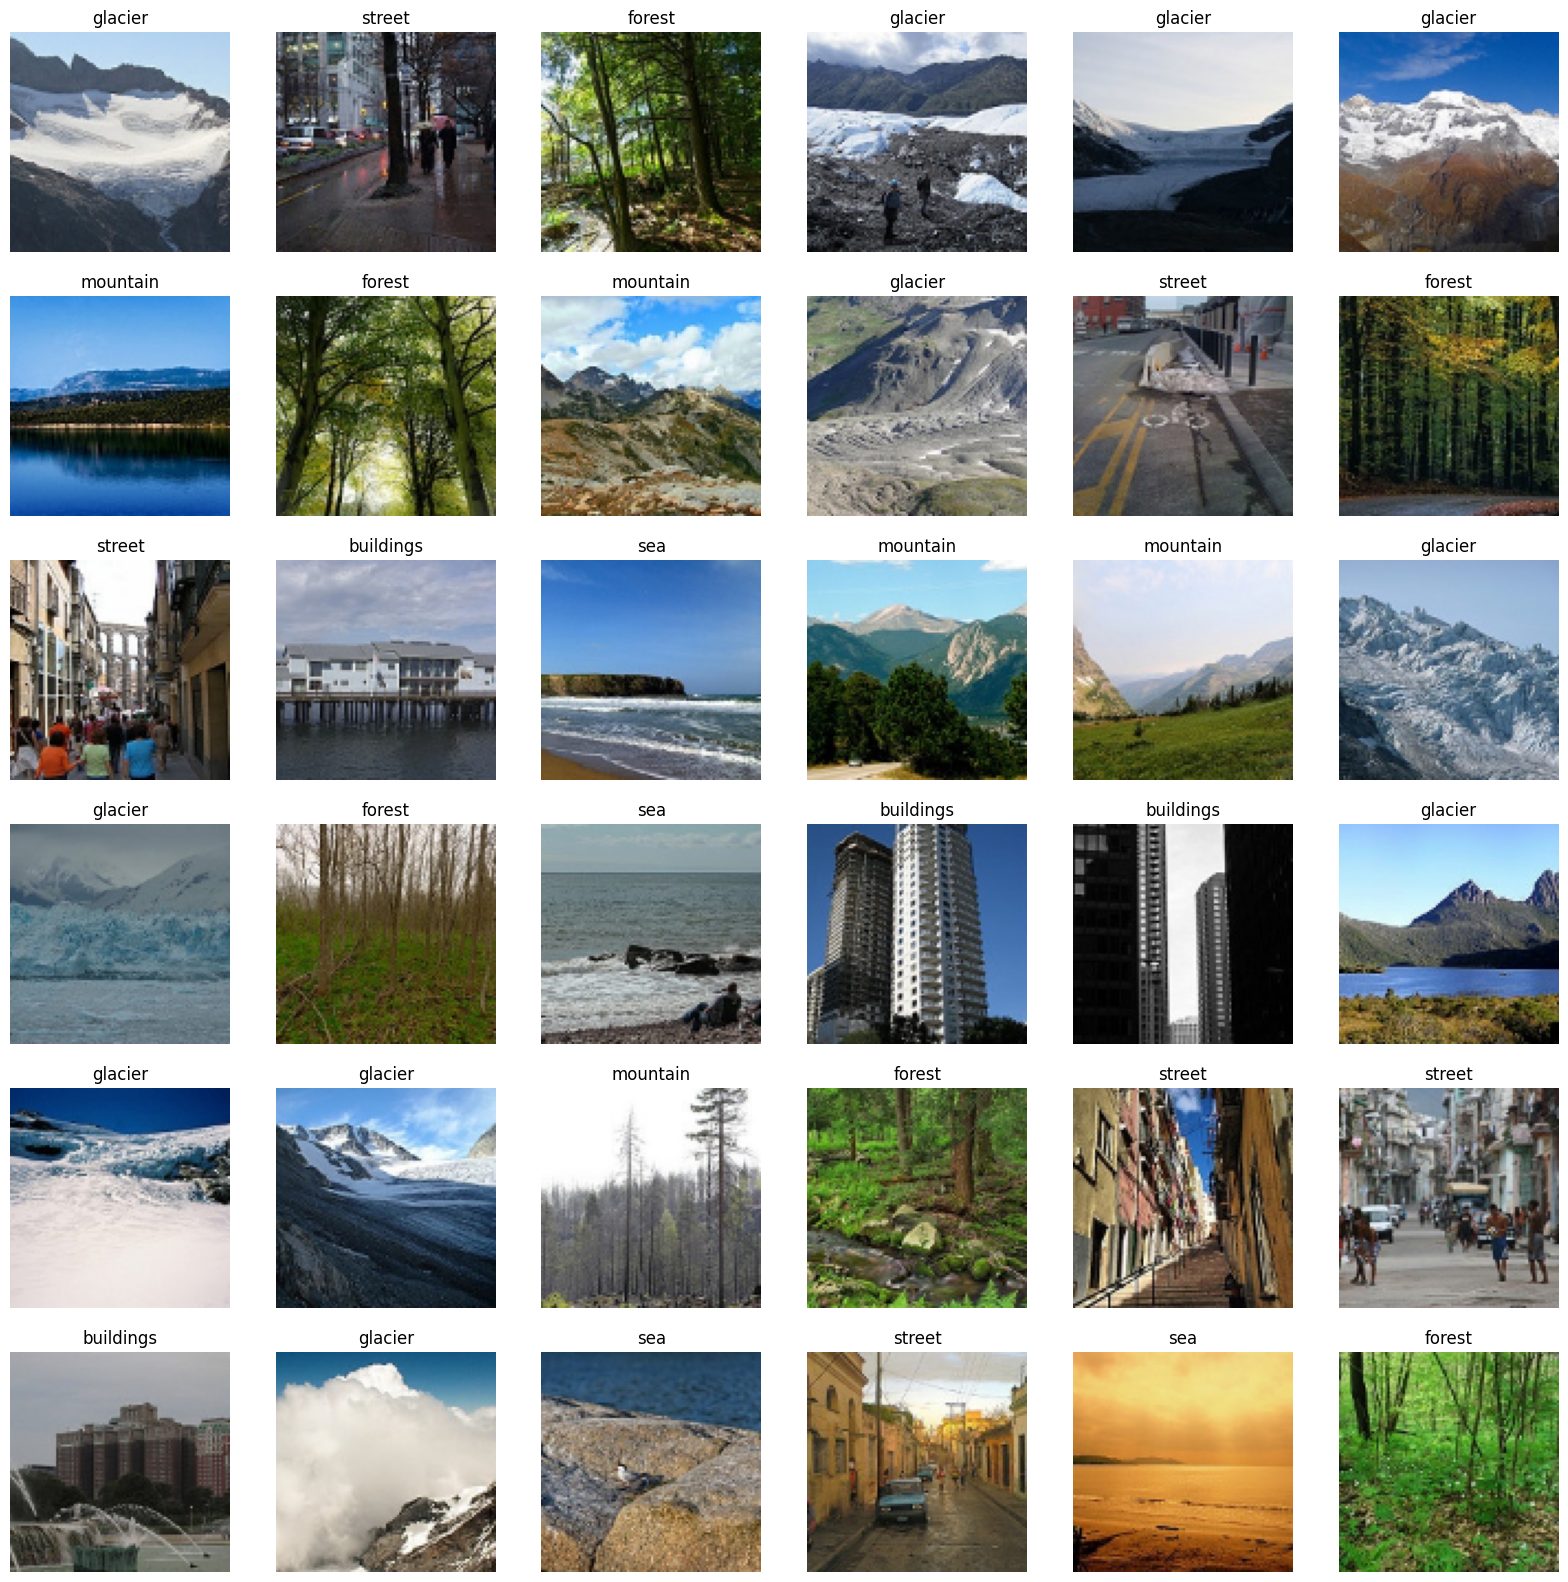

In [21]:
y_result3 = KerasModel.predict(x_pred)
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_pred),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(x_pred[i])
    plt.axis('off')
    plt.title(get_code(np.argmax(y_result3[i])))

In [ ]:
#KerasModel.save(f'/bestkeras_model.h5')

In [ ]:
#KerasModel.save(f'/content/drive/MyDrive/CV_final_project/Weights/best_keras_model.keras')


In [15]:

# Usage for train data
x_train_2, y_train_2 = load_images(train_path, code, resize_shape=(100, 100), is_subfolder=True)

# Usage for test data
x_test_2, y_test_2 = load_images(test_path, code, resize_shape=(100, 100), is_subfolder=True)

# Usage for prediction data (no labels)
# x_pred_2, _ = load_images(pred_path, code=None, resize_shape=(100, 100), is_subfolder=False)


In [16]:
num_classes = 6
xx_train = x_train_2
xx_test = x_test_2
yy_train = to_categorical(np.array(y_train_2), num_classes=6)
yy_test = to_categorical(np.array(y_test_2), num_classes=6)


In [17]:

def data_generator_function(xx_train,yy_train,xx_test , yy_test, model):

    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(
        rescale=1.0/255
    )

    # Create generators
    train_generator = train_datagen.flow(
        xx_train,
        yy_train,
        batch_size=32
    )

    val_generator = val_datagen.flow(
        xx_test,
        yy_test,
        batch_size=32
    )

    return train_generator,val_generator

In [18]:
def vgg16_architecture():
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(100, 100, 3))

    # We must stop the training of the base model layers to keep the model as a feature extractor
    for layer in base_model.layers:
        layer.trainable = False

    # Now we add the new layers to the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)

    VGG16_model = Model(inputs=base_model.input, outputs=output)

    VGG16_model.summary()

    optimizer = Adam(learning_rate=0.0005)
    VGG16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG16_model

In [19]:
def vgg19_architecture():
    base_model = VGG19(include_top=False, weights="imagenet", input_shape=(100,100, 3))

    # We must stop the training of the base model layers to keep the model as a feature extractor
    for layer in base_model.layers:
      layer.trainable = False


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)

    VGG19_model = Model(inputs=base_model.input, outputs=output)

    VGG19_model.summary()

    optimizer = Adam(learning_rate=0.001)
    VGG19_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG19_model

In [20]:
def resnet152v2_architecture():
    base_model = ResNet152V2(include_top=False, weights="imagenet", input_shape=(100,100, 3))

    # We must stop the training of the base model layers to keep the model as a feature extractor
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)

    ResNet152V2_model = Model(inputs=base_model.input, outputs=output)

    ResNet152V2_model.summary()

    optimizer = Adam(learning_rate=0.001)
    ResNet152V2_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return ResNet152V2_model

In [21]:
def inception_v3_architecture():

    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(100,100, 3))

    # We must stop the training of the base model layers to keep the model as a feature extractor
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)

    InceptionV3_model = Model(inputs=base_model.input, outputs=output)

    InceptionV3_model.summary()

    optimizer = Adam(learning_rate=0.001)
    InceptionV3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return InceptionV3_model

In [22]:
def DenseNet_201_architecture():

    base_model = DenseNet201(include_top=False, weights="imagenet", input_shape=(100,100, 3))

    # We must stop the training of the base model layers to keep the model as a feature extractor
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(6, activation='softmax')(x)

    DenseNet_model = Model(inputs=base_model.input, outputs=output)

    DenseNet_model.summary()

    optimizer = Adam(learning_rate=0.001)
    DenseNet_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return DenseNet_model

In [23]:

def evaluate_model(model, x_test, yy_test):
    loss, accuracy = model.evaluate(x_test, yy_test)
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    return loss, accuracy


Training VGG16...
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 2

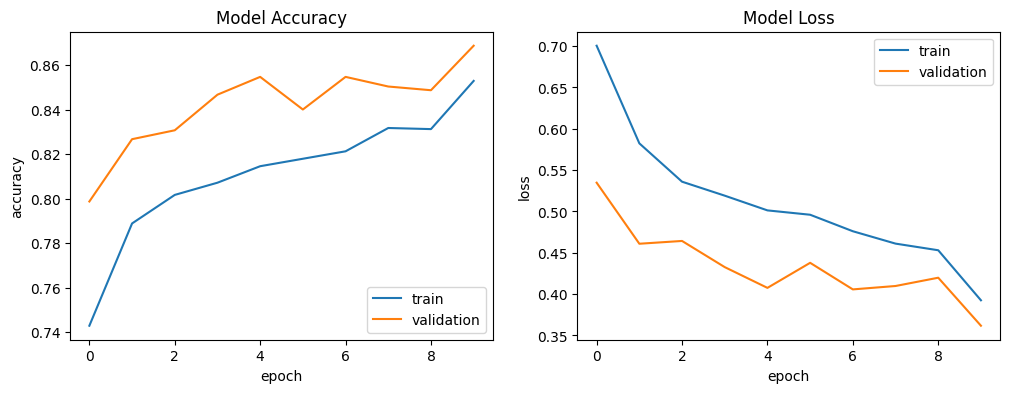

y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


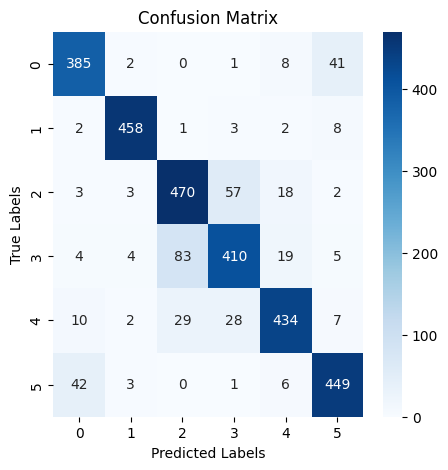

Classification Report:
              precision    recall  f1-score   support

   buildings       0.86      0.88      0.87       437
      forest       0.97      0.97      0.97       474
     glacier       0.81      0.85      0.83       553
    mountain       0.82      0.78      0.80       525
         sea       0.89      0.85      0.87       510
      street       0.88      0.90      0.89       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000

Precision: 0.8691
Recall: 0.8687
F1-score: 0.8686


In [47]:
models = {
     "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
     #"ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
    # "DenseNet": DenseNet_201_architecture
}


for model_name, model_func in models.items():
    # Define the path where you want to save the best model
    desktop_path = os.path.expanduser("~/Desktop/cnn_model")

    # Create generators for the current model
    train_generator,val_generator = data_generator_function(xx_train,yy_train,xx_test , yy_test, model_name)

    # Create a ModelCheckpoint callbackdesktop_path = os.path.expanduser("~/Desktop")
    checkpoint_path = os.path.join(desktop_path, f"{model_name}_checkpoint.keras")

    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Reduce Learning rate when loss is not decreasing
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.001,
        cooldown=0,
        min_lr=0.0000001)

    # Define Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        )

    print(f"Training {model_name}...")
    model = model_func()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        batch_size=256,
        callbacks=[model_checkpoint,early_stop,reduce_lr]
    )

   # Save model files
    model.save(os.path.join(desktop_path, f'best_{model_name}_model.keras'))
    model.save(os.path.join(desktop_path, f'best_{model_name}_model.h5'))


    xx_test = xx_test.astype(np.float32)
    # Now, let's divide each value by 255.0 in batches
    chunksize = 32  # Define the size of each chunk
    for i in range(0, xx_test.shape[0], chunksize):
      end_index = min(i + chunksize, xx_test.shape[0])
      xx_test[i:end_index] /= 255.0  # Divide the chunk by 255.0

    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

    plt.figure(figsize=(12,4))
    #  "Accuracy"
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    #  "Loss"
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)


Training VGG19...
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 2

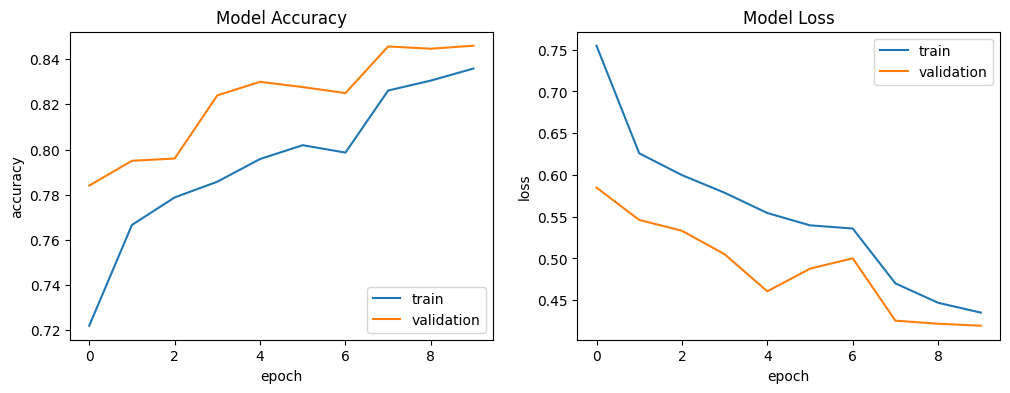

y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


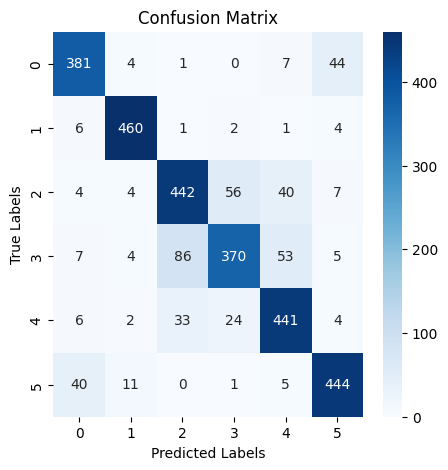

Classification Report:
              precision    recall  f1-score   support

   buildings       0.86      0.87      0.86       437
      forest       0.95      0.97      0.96       474
     glacier       0.79      0.80      0.79       553
    mountain       0.82      0.70      0.76       525
         sea       0.81      0.86      0.83       510
      street       0.87      0.89      0.88       501

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.84      3000

Precision: 0.8455
Recall: 0.8460
F1-score: 0.8448


In [60]:
models = {
    #  "VGG16": vgg16_architecture,
      "VGG19": vgg19_architecture,
    # "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
    # "DenseNet": DenseNet_201_architecture
}


for model_name, model_func in models.items():
    # Define the path where you want to save the best model
    desktop_path = os.path.expanduser("~/Desktop/cnn_model")

    # Create generators for the current model
    train_generator,val_generator = data_generator_function(xx_train,yy_train,xx_test , yy_test, model_name)

    # Create a ModelCheckpoint callbackdesktop_path = os.path.expanduser("~/Desktop")
    checkpoint_path = os.path.join(desktop_path, f"{model_name}_checkpoint.keras")

    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Reduce Learning rate when loss is not decreasing
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.001,
        cooldown=0,
        min_lr=0.0000001)

    # Define Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        )

    print(f"Training {model_name}...")
    model = model_func()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        batch_size=256,
        callbacks=[model_checkpoint,early_stop,reduce_lr]
    )

   # Save model files
    model.save(os.path.join(desktop_path, f'best_{model_name}_model.keras'))
    model.save(os.path.join(desktop_path, f'best_{model_name}_model.h5'))


    xx_test = xx_test.astype(np.float32)
    # Now, let's divide each value by 255.0 in batches
    chunksize = 32  # Define the size of each chunk
    for i in range(0, xx_test.shape[0], chunksize):
      end_index = min(i + chunksize, xx_test.shape[0])
      xx_test[i:end_index] /= 255.0  # Divide the chunk by 255.0

    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

    plt.figure(figsize=(12,4))
    #  "Accuracy"
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    #  "Loss"
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)


Training ResNet152V2...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 52, 52, 64)   0           ['con

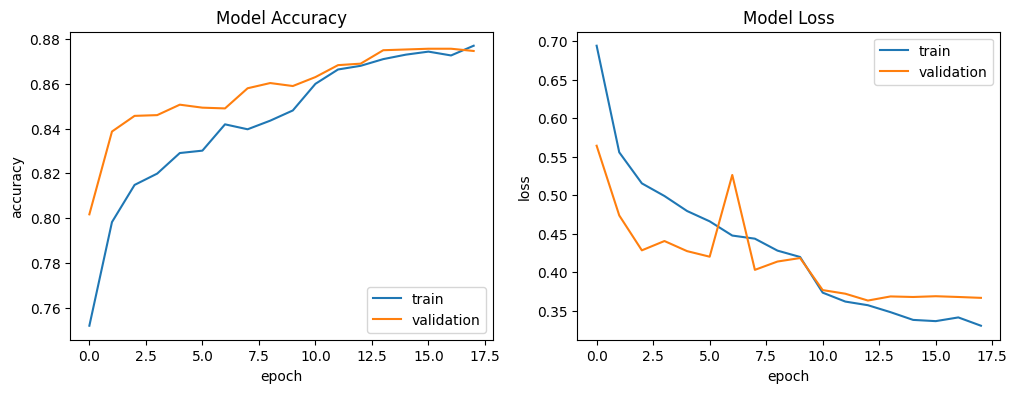

y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


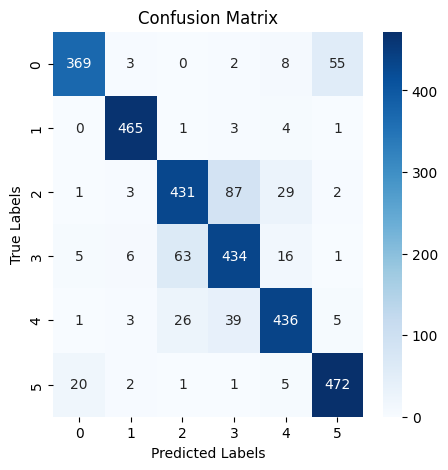

Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.84      0.89       437
      forest       0.96      0.98      0.97       474
     glacier       0.83      0.78      0.80       553
    mountain       0.77      0.83      0.80       525
         sea       0.88      0.85      0.87       510
      street       0.88      0.94      0.91       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000

Precision: 0.8704
Recall: 0.8690
F1-score: 0.8689


In [41]:
models = {
    #  "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
     "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
    # "DenseNet": DenseNet_201_architecture
}


for model_name, model_func in models.items():
    # Define the path where you want to save the best model
    desktop_path = os.path.expanduser("~/Desktop/cnn_model")

    # Create generators for the current model
    train_generator,val_generator = data_generator_function(xx_train,yy_train,xx_test , yy_test, model_name)

    # Create a ModelCheckpoint callbackdesktop_path = os.path.expanduser("~/Desktop")
    checkpoint_path = os.path.join(desktop_path, f"{model_name}_checkpoint.keras")

    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    )

    # Reduce Learning rate when loss is not decreasing
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.001,
        cooldown=0,
        min_lr=0.0000001)

    # Define Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        )

    print(f"Training {model_name}...")
    model = model_func()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        batch_size=256,
        callbacks=[model_checkpoint,early_stop,reduce_lr]
    )

   # Save model files
    model.save(os.path.join(desktop_path, f'best_{model_name}_model.keras'))
    model.save(os.path.join(desktop_path, f'best_{model_name}_model.h5'))


    xx_test = xx_test.astype(np.float32)
    # Now, let's divide each value by 255.0 in batches
    chunksize = 32  # Define the size of each chunk
    for i in range(0, xx_test.shape[0], chunksize):
      end_index = min(i + chunksize, xx_test.shape[0])
      xx_test[i:end_index] /= 255.0  # Divide the chunk by 255.0

    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

    plt.figure(figsize=(12,4))
    #  "Accuracy"
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    #  "Loss"
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)


Training InceptionV3...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 49, 49, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 49, 49, 32)  96          ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                      

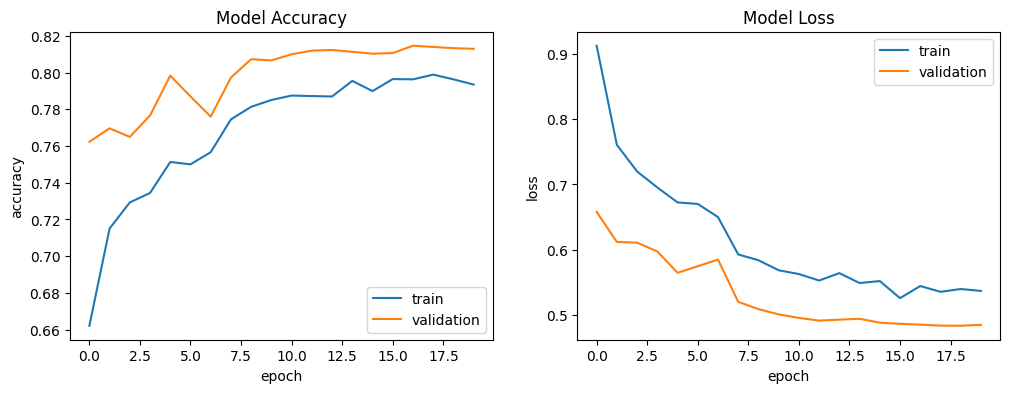

y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


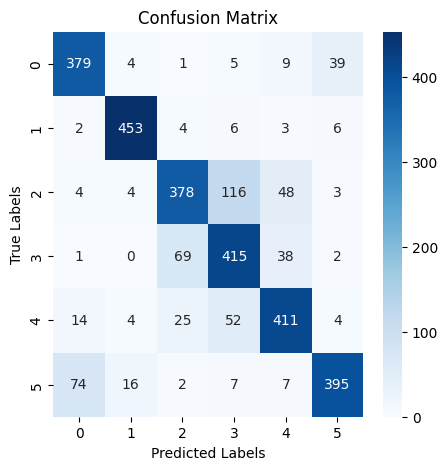

Classification Report:
              precision    recall  f1-score   support

   buildings       0.80      0.87      0.83       437
      forest       0.94      0.96      0.95       474
     glacier       0.79      0.68      0.73       553
    mountain       0.69      0.79      0.74       525
         sea       0.80      0.81      0.80       510
      street       0.88      0.79      0.83       501

    accuracy                           0.81      3000
   macro avg       0.82      0.82      0.81      3000
weighted avg       0.81      0.81      0.81      3000

Precision: 0.8139
Recall: 0.8103
F1-score: 0.8102


In [24]:
models = {
    #  "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
     "InceptionV3": inception_v3_architecture,
    # "DenseNet": DenseNet_201_architecture
}


for model_name, model_func in models.items():
    # Define the path where you want to save the best model
   
    desktop_path = os.path.expanduser("~/Desktop/cnn_model")
    checkpoint_path = os.path.join(desktop_path, f"{model_name}_checkpoint.keras")
    # Create generators for the current model
    train_generator,val_generator = data_generator_function(xx_train,yy_train,xx_test , yy_test, model_name)



    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
)

    # Reduce Learning rate when loss is not decreasing
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.001,
        cooldown=0,
        min_lr=0.0000001)

    # Define Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        )

    print(f"Training {model_name}...")
    model = model_func()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        batch_size=256,
        callbacks=[model_checkpoint,early_stop,reduce_lr]
    )

# Save model files
    model.save(os.path.join(desktop_path, f'best_{model_name}_model.keras'))
    model.save(os.path.join(desktop_path, f'best_{model_name}_model.h5'))



    xx_test = xx_test.astype(np.float32)
    # Now, let's divide each value by 255.0 in batches
    chunksize = 32  # Define the size of each chunk
    for i in range(0, xx_test.shape[0], chunksize):
      end_index = min(i + chunksize, xx_test.shape[0])
      xx_test[i:end_index] /= 255.0  # Divide the chunk by 255.0

    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")

    plt.figure(figsize=(12,4))
    #  "Accuracy"
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    #  "Loss"
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)


Training DenseNet...
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 106, 106, 3)  0          ['input_6[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d_6[0][0]']       
                                                                       

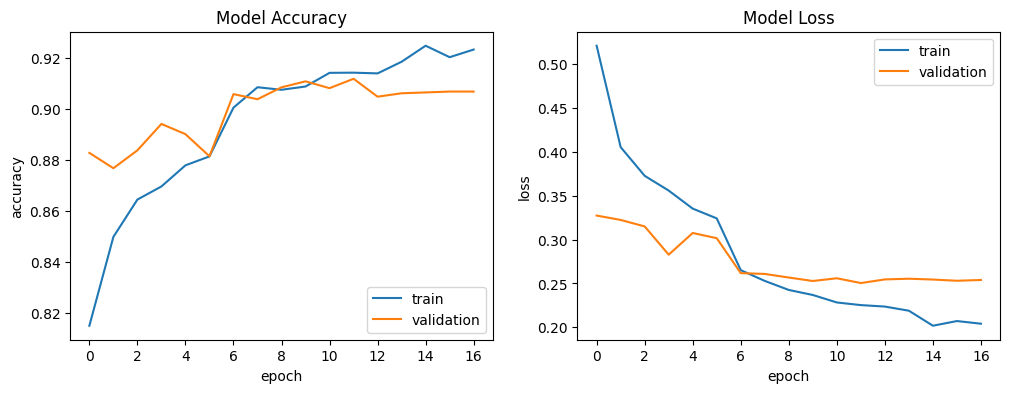

Evaluating DenseNet...
94/94 [==============================] - 105s 1s/step - loss: 0.2504 - accuracy: 0.9117
Loss: 0.2504276633262634
Accuracy: 0.9116666913032532
DenseNet evaluation complete.
Accuracy: 0.9116666913032532

_______________________________________________________________________
y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


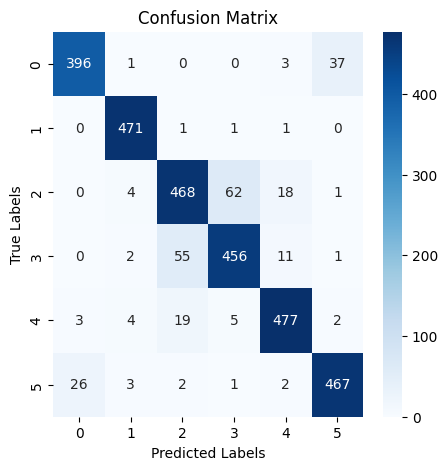

Classification Report:
              precision    recall  f1-score   support

   buildings       0.93      0.91      0.92       437
      forest       0.97      0.99      0.98       474
     glacier       0.86      0.85      0.85       553
    mountain       0.87      0.87      0.87       525
         sea       0.93      0.94      0.93       510
      street       0.92      0.93      0.93       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

Precision: 0.9114
Recall: 0.9117
F1-score: 0.9114


In [36]:
models = {
    #  "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
    "DenseNet": DenseNet_201_architecture
}


for model_name, model_func in models.items():
    # Define the path where you want to save the best model
    desktop_path = os.path.expanduser("~/Desktop/cnn_model")  
    checkpoint_path = os.path.join(desktop_path, f"{model_name}_checkpoint.keras")
    # Create generators for the current model
    train_generator,val_generator = data_generator_function(xx_train,yy_train,xx_test , yy_test, model_name)

    # Create a ModelCheckpoint callback
    model_checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
        save_best_only=True,  # Save only the best model
        mode='min',  # 'min' for loss, 'max' for accuracy
        verbose=1  # Verbosity mode, 1 = save messages
    )

    # Reduce Learning rate when loss is not decreasing
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=2,
        verbose=1,
        mode='auto',
        min_delta=0.001,
        cooldown=0,
        min_lr=0.0000001)

    # Define Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        min_delta=0.005,
        patience=5,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        )

    print(f"Training {model_name}...")
    model = model_func()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=25,
        batch_size=256,
        callbacks=[model_checkpoint,early_stop,reduce_lr]
    )
    model.save(os.path.join(desktop_path, f'best_{model_name}_model.keras'))
    model.save(os.path.join(desktop_path, f'best_{model_name}_model.h5'))

    plt.figure(figsize=(12,4))
    #  "Accuracy"
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    #  "Loss"
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

    xx_test = xx_test.astype(np.float32)
    # Now, let's divide each value by 255.0 in batches
    chunksize = 32  # Define the size of each chunk
    for i in range(0, xx_test.shape[0], chunksize):
      end_index = min(i + chunksize, xx_test.shape[0])
      xx_test[i:end_index] /= 255.0  # Divide the chunk by 255.0

    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_______________________________________________________________________")



    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)

## In the code above, I have provided you with a written code, but it contains errors. Each of you must trace the errors and improve the accuracy for each model, recording the changes in the table below. Then, answer the following questions.

# Experimental Results 

| Network          | Accuracy | Recall | Precision | F1-Score |
|------------------|----------|--------|-----------|----------|
| Your CNN model   |   0.82   | 0.8193 |  0.8296   |  0.8203  |
| VGG16            |   0.87   | 0.8687 |  0.8691   |  0.8686  |
| VGG19            |   0.85   | 0.8460 |  0.8455   |  0.8448  |
| RasNet152V2      |   0.87   | 0.8690 |  0.8704   |  0.8689  |
| Inception_V3     |   0.81   | 0.8139 |  0.8103   |  0.8102  |
| DenseNet         |   0.91   | 0.9117 |  0.9114   |  0.9114  |


# Ensemble

# Weighted Ensemble

Individual Model Accuracies: [0.8163333333333334, 0.619, 0.49866666666666665, 0.17, 0.13866666666666666, 0.24066666666666667]
Normalized Weights: [0.3287248322147651, 0.24926174496644293, 0.20080536912751676, 0.06845637583892618, 0.05583892617449664, 0.09691275167785235]

Weighted Ensemble Accuracy: 0.7387


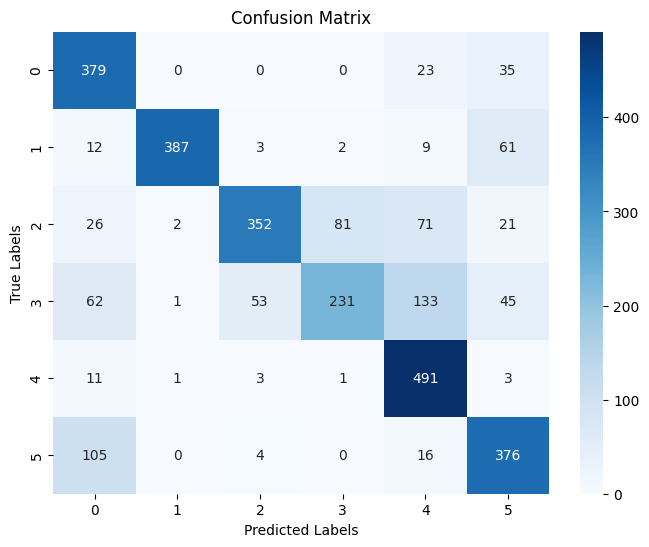

              precision    recall  f1-score   support

           0       0.64      0.87      0.73       437
           1       0.99      0.82      0.89       474
           2       0.85      0.64      0.73       553
           3       0.73      0.44      0.55       525
           4       0.66      0.96      0.78       510
           5       0.70      0.75      0.72       501

    accuracy                           0.74      3000
   macro avg       0.76      0.75      0.74      3000
weighted avg       0.76      0.74      0.73      3000



In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def ensemble_predictions(models, x_data, weights=None):
    """
    Combine predictions using weighted averaging.
    """
    predictions = [model.predict(x_data) for model in models]

    if weights is None:
        weights = [1.0 / len(models)] * len(models)  # Equal weights if not provided

    weighted_preds = np.zeros_like(predictions[0])
    for pred, weight in zip(predictions, weights):
        weighted_preds += pred * weight

    return weighted_preds

def generate_confusion_matrix_and_metrics(predictions, y_test):
    """
    Generate confusion matrix and classification report from the predictions.
    """
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    print(classification_report(y_true, y_pred))

# Load models
CNN_model = load_model('C:/Users/osc/Desktop/bestmodel.h5')
VGG16_model = load_model('C:/Users/osc/Desktop/cnn_model/best_VGG16_model.h5')
VGG19_model = load_model('C:/Users/osc/Desktop/cnn_model/best_VGG19_model.h5')
ResNet152V2_model = load_model('C:/Users/osc/Desktop/cnn_model/best_ResNet152V2_model.h5')
InceptionV3_model = load_model('C:/Users/osc/Desktop/cnn_model/best_InceptionV3_model.h5')
DenseNet_model = load_model('C:/Users/osc/Desktop/cnn_model/best_DenseNet_model.h5')

trained_models = [CNN_model, VGG16_model, VGG19_model, ResNet152V2_model, InceptionV3_model, DenseNet_model]

# Calculate individual model accuracies
individual_accuracies = []
y_true = np.argmax(y_test, axis=1)

for model in trained_models:
    preds = model.predict(x_test)
    pred_classes = np.argmax(preds, axis=1)
    acc = accuracy_score(y_true, pred_classes)
    individual_accuracies.append(acc)

# Normalize accuracies to use as weights
total = sum(individual_accuracies)
weights = [acc / total for acc in individual_accuracies]

print("Individual Model Accuracies:", individual_accuracies)
print("Normalized Weights:", weights)

# Get weighted ensemble predictions
ensemble_preds = ensemble_predictions(trained_models, x_test, weights=weights)

# Evaluate
ensemble_classes = np.argmax(ensemble_preds, axis=1)
ensemble_accuracy = accuracy_score(y_true, ensemble_classes)
print(f"\nWeighted Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Metrics and Confusion Matrix
generate_confusion_matrix_and_metrics(ensemble_preds, y_test)


# Train meta-model (logistic regression)


Stacked Model Accuracy: 0.8873


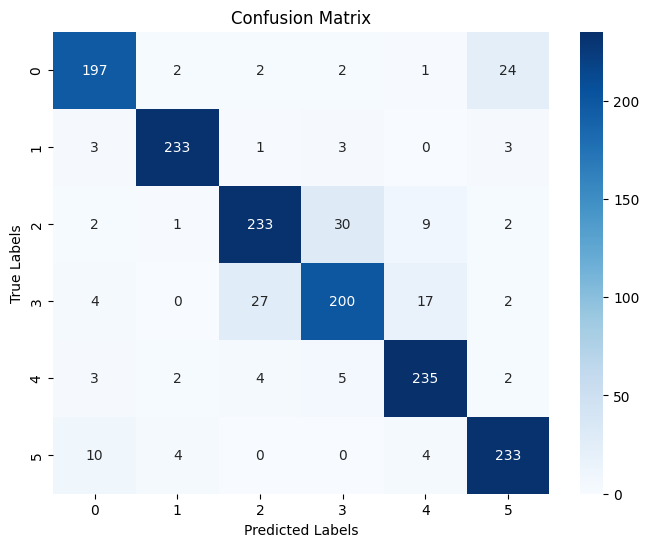

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       228
           1       0.96      0.96      0.96       243
           2       0.87      0.84      0.86       277
           3       0.83      0.80      0.82       250
           4       0.88      0.94      0.91       251
           5       0.88      0.93      0.90       251

    accuracy                           0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



['C:/Users/osc/Desktop/cnn_model/stacked_meta_model.pkl']

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib

def generate_confusion_matrix_and_metrics(predictions, y_true):
    """
    Generate confusion matrix and classification report.
    """
    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    print(classification_report(y_true, predictions))


# Load models
CNN_model = load_model('C:/Users/osc/Desktop/bestmodel.h5')
VGG16_model = load_model('C:/Users/osc/Desktop/cnn_model/best_VGG16_model.h5')
VGG19_model = load_model('C:/Users/osc/Desktop/cnn_model/best_VGG19_model.h5')
ResNet152V2_model = load_model('C:/Users/osc/Desktop/cnn_model/best_ResNet152V2_model.h5')
InceptionV3_model = load_model('C:/Users/osc/Desktop/cnn_model/best_InceptionV3_model.h5')
DenseNet_model = load_model('C:/Users/osc/Desktop/cnn_model/best_DenseNet_model.h5')

base_models = [CNN_model, VGG16_model, VGG19_model, ResNet152V2_model, InceptionV3_model, DenseNet_model]

# Split x_test and y_test into validation and final test sets for stacking
x_val, x_final_test, y_val, y_final_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Convert labels from one-hot to class labels
y_val_classes = np.argmax(y_val, axis=1)
y_final_classes = np.argmax(y_final_test, axis=1)

# Create meta features for training (validation set)
meta_features_train = []
for model in base_models:
    preds = model.predict(x_val)
    meta_features_train.append(preds)
meta_features_train = np.concatenate(meta_features_train, axis=1)  # Shape: (samples, models × classes)

# Train meta-model (logistic regression)
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(meta_features_train, y_val_classes)

# Create meta features for testing (final test set)
meta_features_test = []
for model in base_models:
    preds = model.predict(x_final_test)
    meta_features_test.append(preds)
meta_features_test = np.concatenate(meta_features_test, axis=1)

# Predict using meta-model
stacked_preds = meta_model.predict(meta_features_test)
stacked_acc = accuracy_score(y_final_classes, stacked_preds)
print(f"\nStacked Model Accuracy: {stacked_acc:.4f}")

# Generate classification report and confusion matrix
generate_confusion_matrix_and_metrics(stacked_preds, y_final_classes)


joblib.dump(meta_model, "C:/Users/osc/Desktop/cnn_model/stacked_meta_model.pkl")


In [31]:
!pip install xgboost


You should consider upgrading via the 'G:\data science certificates\GUI project\myenv310\Scripts\python.exe -m pip install --upgrade pip' command.


Evaluating Random Forest with 5-fold CV on meta-features...
Average CV Accuracy for Random Forest: 0.8707
Evaluating XGBoost with 5-fold CV on meta-features...


g:\data science certificates\GUI project\myenv310\lib\site-packages\xgboost\training.py:183: UserWarning: [18:49:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
g:\data science certificates\GUI project\myenv310\lib\site-packages\xgboost\training.py:183: UserWarning: [18:49:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
g:\data science certificates\GUI project\myenv310\lib\site-packages\xgboost\training.py:183: UserWarning: [18:49:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
g:\data science certificates\GUI project\myenv310\lib\site-packages\xgboost\training.py:183: UserWarning: [18:49:17] WARNING: C:\actions-runner\_work\xgbo

Average CV Accuracy for XGBoost: 0.8627
Evaluating MLP Neural Network with 5-fold CV on meta-features...


g:\data science certificates\GUI project\myenv310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
g:\data science certificates\GUI project\myenv310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
g:\data science certificates\GUI project\myenv310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
g:\data science certificates\GUI project\myenv310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Average CV Accuracy for MLP Neural Network: 0.8213

Final Accuracy on test set: 0.8846666666666667


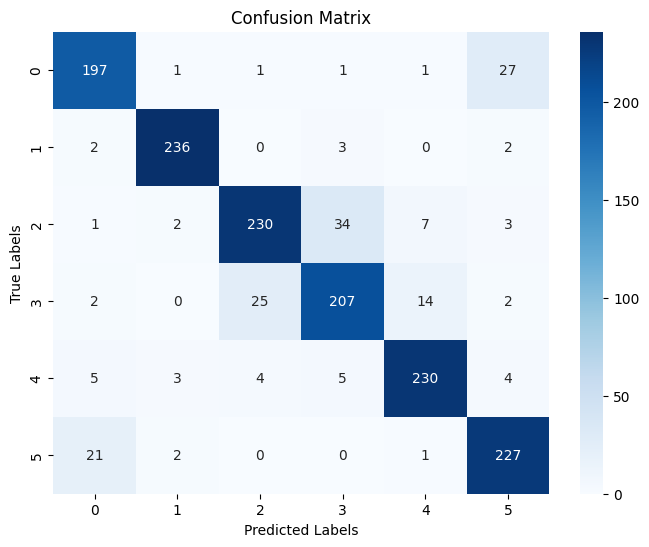

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       228
           1       0.97      0.97      0.97       243
           2       0.88      0.83      0.86       277
           3       0.83      0.83      0.83       250
           4       0.91      0.92      0.91       251
           5       0.86      0.90      0.88       251

    accuracy                           0.88      1500
   macro avg       0.88      0.89      0.89      1500
weighted avg       0.88      0.88      0.88      1500



In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.models import load_model

def generate_confusion_matrix_and_metrics(predictions, y_true):
    cm = confusion_matrix(y_true, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    print(classification_report(y_true, predictions))

# Load base models
CNN_model = load_model('C:/Users/osc/Desktop/bestmodel.h5')
VGG16_model = load_model('C:/Users/osc/Desktop/cnn_model/best_VGG16_model.h5')
VGG19_model = load_model('C:/Users/osc/Desktop/cnn_model/best_VGG19_model.h5')
ResNet152V2_model = load_model('C:/Users/osc/Desktop/cnn_model/best_ResNet152V2_model.h5')
InceptionV3_model = load_model('C:/Users/osc/Desktop/cnn_model/best_InceptionV3_model.h5')
DenseNet_model = load_model('C:/Users/osc/Desktop/cnn_model/best_DenseNet_model.h5')

base_models = [CNN_model, VGG16_model, VGG19_model, ResNet152V2_model, InceptionV3_model, DenseNet_model]

# Split test set into validation and final test sets for stacking
x_val, x_final_test, y_val, y_final_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Convert one-hot labels to class indices
y_val_classes = np.argmax(y_val, axis=1)
y_final_classes = np.argmax(y_final_test, axis=1)

# Create meta features for training (validation set)
meta_features_train = []
for model in base_models:
    preds = model.predict(x_val)
    meta_features_train.append(preds)
meta_features_train = np.concatenate(meta_features_train, axis=1)  # shape (samples, models × classes)

# Create meta features for final test set
meta_features_test = []
for model in base_models:
    preds = model.predict(x_final_test)
    meta_features_test.append(preds)
meta_features_test = np.concatenate(meta_features_test, axis=1)

# Define meta-models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
mlp_pipeline = make_pipeline(
    StandardScaler(),
    MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
)

models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "MLP Neural Network": mlp_pipeline
}

# Cross-validation on meta_features_train
for name, model in models.items():
    print(f"Evaluating {name} with 5-fold CV on meta-features...")
    cv_scores = cross_val_score(model, meta_features_train, y_val_classes, cv=5, scoring='accuracy')
    print(f"Average CV Accuracy for {name}: {np.mean(cv_scores):.4f}")

# Pick best model (e.g. XGBoost), fit on entire meta_features_train
best_meta_model = xgb_model
best_meta_model.fit(meta_features_train, y_val_classes)

# Predict on final test meta features
stacked_preds = best_meta_model.predict(meta_features_test)

# Final evaluation on test set
print("\nFinal Accuracy on test set:", accuracy_score(y_final_classes, stacked_preds))
generate_confusion_matrix_and_metrics(stacked_preds, y_final_classes)


| Meta-Model           | Accuracy on Hold-out | Comments                                               |
|----------------------|---------------------|--------------------------------------------------------|
| Random Forest        | 0.8707 (CV)         | Strong and stable                                      |
| XGBoost              | 0.8627 (CV)         | Close to RF, still strong                              |
| MLP Neural Network   | 0.8213 (CV)         | Lower performance, convergence issues                  |
| Logistic Regression  | 0.8873 (Test)       | ⭐️ Best performance so far — simple, fast, and very interpretable |